In [1]:
from PIL import Image
from torchvision.transforms import ToTensor
import torchvision.models as models
import os
from random import shuffle
import torchsummary
import torch
import torch.nn as nn
import time
import numpy as np
import matplotlib.pyplot as plt
import gc

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(device)

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device, decr_coeff = 1, decr_ep_n = 10):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_loss = []
    train_accuracy = []
    val_accuracy = []
    counter = 0
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_val_loss = []
        ep_train_accuracy = []
        ep_val_accuracy = []
        start_time = time.time()
        counter += 1
        if counter == decr_ep_n:
            counter = 0
            for g in opt.param_groups:
                g['lr'] = g['lr'] / decr_coeff

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            out = model(X_batch)
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(torch_accuracy_score(y_batch, model(X_batch)))

        model.train(False) # disable dropout / use averages for batch_norm
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                # move data to target device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
                out = model(X_batch)
                loss = loss_fn(out, y_batch)

                # compute predictions
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_val_accuracy.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))

        val_loss.append(np.mean(ep_val_loss))
        val_accuracy.append(np.mean(ep_val_accuracy))

        print(f"\t training loss: {train_loss[-1]:.6f}")
        print(f"\t training accuracy: {train_accuracy[-1]:.6f}")
        print(f"\t validation loss: {val_loss[-1]:.6f}")
        print(f"\t validation accuracy: {val_accuracy[-1]:.3f}")

    return train_loss, train_accuracy, val_loss, val_accuracy

def torch_accuracy_score(y_true, predictions):
    y_pred = predictions.max(dim=1)[1]
    return np.mean(np.array(y_true.cpu() == y_pred.cpu()))

def plot_training(tr_loss, tr_acc, val_loss, val_acc):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    axes[0].set_title('Accuracy')
    axes[0].plot(tr_acc, label='Training accuracy')
    axes[0].plot(val_acc, label='Validation accuracy')
    axes[0].set_xlabel('n epoch')
    axes[0].grid(True)
    axes[0].legend()

    axes[1].set_title('Loss')
    axes[1].plot(tr_loss, label='Training loss')
    axes[1].plot(val_loss, label='Validation loss')
    axes[1].set_xlabel('n epoch')
    axes[1].grid(True)
    axes[1].legend()

    plt.show()

def model_test_score(model, test_loader):
    test_accuracy = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            predictions = model(X_batch)
            test_accuracy.append(torch_accuracy_score(y_batch.flatten(), predictions))

    return np.mean(test_accuracy)


cuda


### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

#### Результаты:

Сначала я пытался создать и обучить ванильную свёрточную сеть, но, как можно догадаться,
у меня ничего не вышло.

Потом я подтянул предобученный ResNet-152 и результат стал значительно лучше
(пруфы снизу).



In [2]:
# Your experiments here


In [2]:
def process_im(image):
    x, y = image.size
    max_size = max(x,y)
    hms = int(max_size/2)
    lh_x = 0
    lh_y = 0
    if x > y:
        lh_y = int(hms - y/2)
    else:
        lh_x = int(hms - x/2)
    new_image = Image.new("RGB", (max_size, max_size), color=0)
    new_image.paste(image,(lh_x,lh_y,lh_x+x,lh_y+y))
    new_image = new_image.resize((224,224))
    # new_image.transpose(Image.FLIP_LEFT_RIGHT).show()

    return ToTensor()(new_image)

In [3]:
img_path = "data/train/0/63.jpeg"
init_image = Image.open(img_path)
process_im(init_image).shape

torch.Size([3, 224, 224])

In [3]:
data = list()
for i in range(0, 50):
    for j in range(0,200):
        if os.path.isfile("data/train/"+str(i)+"/"+str(j)+".jpeg"):
            img_path = "data/train/"+str(i)+"/"+str(j)+".jpeg"
            init_image = Image.open(img_path)
            data.append((process_im(init_image), int(i)))
            # data.append((process_im(init_image.rotate(angle=20)), int(i)))
            # data.append((process_im(init_image.rotate(angle=-20)), int(i)))
            mirrored_image = init_image.transpose(Image.FLIP_LEFT_RIGHT)
            data.append((process_im(mirrored_image), int(i)))
            # data.append((process_im(mirrored_image.rotate(angle=20)), int(i)))
            # data.append((process_im(mirrored_image.rotate(angle=-20)), int(i)))

shuffle(data)

In [5]:
for x, y in data:
    print(x.shape)
    break

print(len(data))

torch.Size([3, 224, 224])
14228


In [4]:
split_index1 = int(0.8 * data.__len__())
split_index2 = int(0.9 * data.__len__())
train_dataset, val_dataset, test_dataset = data[:split_index1], data[split_index1:split_index2], data[split_index2:]
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
gc.collect()

11382
1423
1423


19

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                           batch_size=16,
                                           shuffle = False,
                                           num_workers = 0)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          num_workers=0)

for x, y in train_loader:
    print(x.shape)
    break

torch.Size([16, 3, 224, 224])


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_shape=3*256*256, num_classes=50, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=257, stride=1, padding=128), # out 256
            nn.BatchNorm2d(3),
            nn.ReLU(),

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=257, stride=1, padding=128), # out 256
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # out 128

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=129, stride=1, padding=64),# out 128
            nn.BatchNorm2d(3),
            nn.ReLU(),

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=129, stride=1, padding=64),# out 128
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),# out 64

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=65, stride=1, padding=32),# out 64
            nn.BatchNorm2d(3),
            nn.ReLU(),

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=65, stride=1, padding=32),# out 64
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),# out 32

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33, stride=1, padding=16),# out 32
            nn.BatchNorm2d(3),
            nn.ReLU(),

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33, stride=1, padding=16),# out 32
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),# out 16

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=17, stride=1, padding=8),# out 16
            nn.BatchNorm2d(3),
            nn.ReLU(),

            # ================================================================
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=17, stride=1, padding=8),# out 16
            nn.BatchNorm2d(3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2), # out 8 => 8*8*3=192
            # ================================================================
            nn.Flatten(),
            nn.Linear(192, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

torchsummary.summary(NeuralNetwork().to(device), (3,256,256))

In [31]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=3*256*256, num_classes=50, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=33),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(3*1024, 512),
            nn.BatchNorm1d(512, eps = 1e-3, momentum = 0.1),
            nn.LeakyReLU(),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

torchsummary.summary(TinyNeuralNetwork().to(device), (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 3, 224, 224]           9,804
       BatchNorm2d-2          [-1, 3, 224, 224]               6
              Tanh-3          [-1, 3, 224, 224]               0
            Conv2d-4          [-1, 3, 192, 192]           9,804
       BatchNorm2d-5          [-1, 3, 192, 192]               6
              Tanh-6          [-1, 3, 192, 192]               0
            Conv2d-7          [-1, 3, 160, 160]           9,804
       BatchNorm2d-8          [-1, 3, 160, 160]               6
              Tanh-9          [-1, 3, 160, 160]               0
           Conv2d-10          [-1, 3, 128, 128]           9,804
      BatchNorm2d-11          [-1, 3, 128, 128]               6
             Tanh-12          [-1, 3, 128, 128]               0
           Conv2d-13            [-1, 3, 96, 96]           9,804
      BatchNorm2d-14            [-1, 3,

In [38]:
n_epochs = 15
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3, betas=(0.9,0.95), eps=0.99) # YOUR CODE HERE
loss_func = nn.NLLLoss() # YOUR CODE HERE

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=1, decr_ep_n=5)

Epoch 1 of 15 took 447.933s
	 training loss: 4.244641
	 training accuracy: 0.029399
	 validation loss: 4.151382
	 validation accuracy: 0.024
Epoch 2 of 15 took 449.960s
	 training loss: 3.999197
	 training accuracy: 0.043579
	 validation loss: 4.016223
	 validation accuracy: 0.041
Epoch 3 of 15 took 448.991s
	 training loss: 3.940243
	 training accuracy: 0.047861
	 validation loss: 3.946295
	 validation accuracy: 0.036
Epoch 4 of 15 took 448.044s
	 training loss: 3.902750
	 training accuracy: 0.048323
	 validation loss: 3.924788
	 validation accuracy: 0.037
Epoch 5 of 15 took 447.892s
	 training loss: 3.870261
	 training accuracy: 0.048470
	 validation loss: 3.902748
	 validation accuracy: 0.044
Epoch 6 of 15 took 448.163s
	 training loss: 3.849815
	 training accuracy: 0.053649
	 validation loss: 3.889932
	 validation accuracy: 0.047
Epoch 7 of 15 took 448.179s
	 training loss: 3.827574
	 training accuracy: 0.051998
	 validation loss: 3.880684
	 validation accuracy: 0.038
Epoch 8 of 15

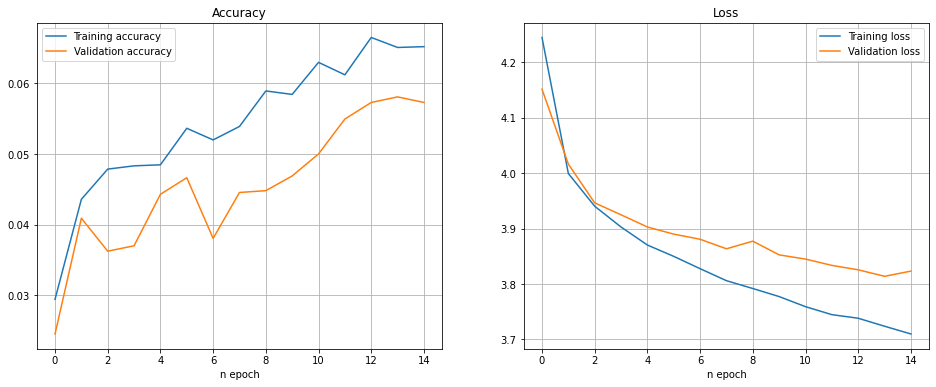

In [39]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [40]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))

test accuracy:	0.053


In [6]:
class ResNet(nn.Module):
    def __init__(self, input_shape=3*224*224, num_classes=50, input_channels=3):
        super(self.__class__, self).__init__()
        self.model = models.resnet152(pretrained=True)
        self.model.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.Dropout(0.3),
            nn.BatchNorm1d(1024, eps = 1e-3, momentum = 0.1),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.Dropout(0.3),
            nn.BatchNorm1d(512, eps = 1e-3, momentum = 0.1),
            nn.ReLU(),
            nn.Linear(512, num_classes),
            nn.BatchNorm1d(num_classes, eps = 1e-3, momentum = 0.1),
            nn.LogSoftmax(dim = 1)
        )

    def forward(self, inp):
        out = self.model(inp)
        return out

# print(resnet)

# torchsummary.summary(ResNet().to(device), (3,224,224))

In [7]:
n_epochs = 15
model = ResNet().to(device)
# opt = torch.optim.Adam(model.parameters(), lr = 1e-3, betas=(0.9,0.95), eps=0.99) # YOUR CODE HERE
opt = torch.optim.SGD(model.parameters(), lr = 1e-3, momentum = 0.99)
loss_func = nn.NLLLoss() # YOUR CODE HERE

tr_loss, tr_acc, val_loss, val_acc = train_model(model, train_loader, val_loader,
                                                 loss_fn=loss_func, opt=opt, n_epochs=n_epochs,
                                                 decr_coeff=2, decr_ep_n=2)

Epoch 1 of 15 took 538.453s
	 training loss: 2.213426
	 training accuracy: 0.424157
	 validation loss: 1.616015
	 validation accuracy: 0.550


KeyboardInterrupt: 

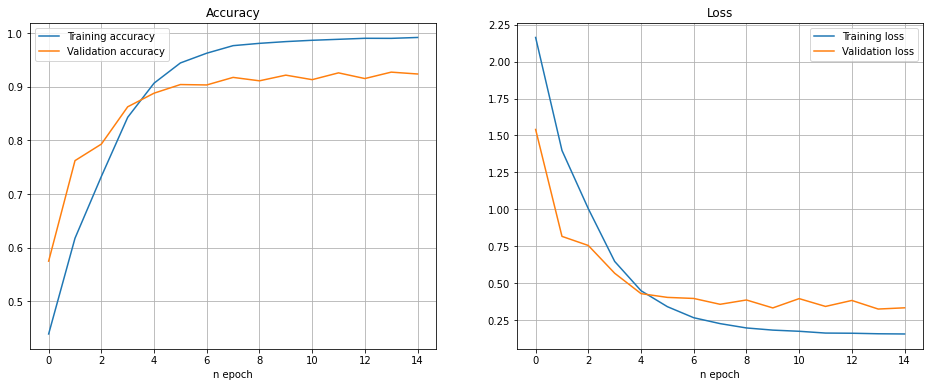

In [18]:
plot_training(tr_loss, tr_acc, val_loss, val_acc)

In [19]:
model.eval()
test_acc = model_test_score(model, test_loader)
print('test accuracy:\t{:.3f}'.format(test_acc))



test accuracy:	0.913
